# Feature: Out-Of-Fold Predictions from a CNN (+Magic Inputs)

In addition to the convolutional architecture, we'll append some of the leaky features to the intermediate feature layer.

<img src="assets/cnn-with-magic.png" alt="Network Architecture" style="height: 1200px;" />

## Imports

This utility package imports `numpy`, `pandas`, `matplotlib` and a helper `kg` module into the root namespace.

In [1]:
from pygoose import *

In [2]:
import gc

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *

In [5]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## Config

Automatically discover the paths to various data folders and compose the project structure.

In [6]:
project = kg.Project.discover()

Identifier for storing these features on disk and referring to them later.

In [7]:
feature_list_id = 'oofp_nn_cnn_with_magic'

Make subsequent NN runs reproducible.

In [8]:
RANDOM_SEED = 42

In [9]:
np.random.seed(RANDOM_SEED)

## Read data

Word embedding lookup matrix.

In [10]:
embedding_matrix = kg.io.load(project.aux_dir + 'fasttext_vocab_embedding_matrix.pickle')

Padded sequences of word indices for every question.

In [11]:
X_train_q1 = kg.io.load(project.preprocessed_data_dir + 'sequences_q1_fasttext_train.pickle')
X_train_q2 = kg.io.load(project.preprocessed_data_dir + 'sequences_q2_fasttext_train.pickle')

In [12]:
X_test_q1 = kg.io.load(project.preprocessed_data_dir + 'sequences_q1_fasttext_test.pickle')
X_test_q2 = kg.io.load(project.preprocessed_data_dir + 'sequences_q2_fasttext_test.pickle')

In [13]:
y_train = kg.io.load(project.features_dir + 'y_train.pickle')

Magic features.

In [14]:
magic_feature_lists = [
    'magic_frequencies',
    'magic_cooccurrence_matrix',
]

In [15]:
X_train_magic, X_test_magic, _ = project.load_feature_lists(magic_feature_lists)

In [16]:
X_train_magic = X_train_magic.values
X_test_magic = X_test_magic.values

In [17]:
scaler = StandardScaler()
scaler.fit(np.vstack([X_train_magic, X_test_magic]))
X_train_magic = scaler.transform(X_train_magic)
X_test_magic = scaler.transform(X_test_magic)

Word embedding properties.

In [18]:
EMBEDDING_DIM = embedding_matrix.shape[-1]
VOCAB_LENGTH = embedding_matrix.shape[0]
MAX_SEQUENCE_LENGTH = X_train_q1.shape[-1]

In [19]:
print(EMBEDDING_DIM, VOCAB_LENGTH, MAX_SEQUENCE_LENGTH)

300 101564 30


## Define models

In [20]:
init_weights = initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=2)
init_bias = 'zeros'

In [21]:
def create_embedding_block():
    input_seq = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
    
    embedding_seq = Embedding(
        VOCAB_LENGTH,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False,
    )(input_seq)
    
    output_seq = embedding_seq
    return input_seq, output_seq

In [22]:
def create_model_question_conv_branch(input_seq, params):
    conv_1 = Conv1D(
        params['num_conv_filters'],
        kernel_size=params['conv_kernel_size'],
        padding='same',
    )(input_seq)
    
    bn_1 = BatchNormalization()(conv_1)
    relu_1 = Activation('relu')(bn_1)
    dropout_1 = Dropout(params['conv_dropout_rate'])(relu_1)

    conv_2 = Conv1D(
        params['num_conv_filters'],
        kernel_size=params['conv_kernel_size'],
        padding='same',
    )(dropout_1)
    
    bn_2 = BatchNormalization()(conv_2)
    relu_2 = Activation('relu')(bn_2)
    dropout_2 = Dropout(params['conv_dropout_rate'])(relu_2)
    
    flatten = Flatten()(dropout_2)
    output = flatten
    
    return output

In [23]:
def create_model_question_timedist_max_branch(input_seq, params):
    timedist = TimeDistributed(Dense(EMBEDDING_DIM))(input_seq)
    bn = BatchNormalization()(timedist)
    relu = Activation('relu')(bn)
    dropout = Dropout(params['timedist_dropout_rate'])(relu)

    lambda_max = Lambda(
        lambda x: K.max(x, axis=1),
        output_shape=(EMBEDDING_DIM, )
    )(dropout)
    
    output = lambda_max
    return output

In [24]:
def create_dense_block(input_layer, num_units, dropout_rate):
    dense = Dense(
        num_units,
        kernel_initializer=init_weights,
        bias_initializer=init_bias,
    )(input_layer)
    bn = BatchNormalization()(dense)
    relu = Activation('relu')(bn)
    dropout = Dropout(dropout_rate)(relu)
    output = dropout
    
    return output

In [25]:
def create_model(params):
    input_q1, emb_q1 = create_embedding_block()
    input_q2, emb_q2 = create_embedding_block()
    
    # Feature extractors.
    conv_q1_output = create_model_question_conv_branch(emb_q1, params)
    conv_q2_output = create_model_question_conv_branch(emb_q2, params)
    
    timedist_q1_output = create_model_question_timedist_max_branch(emb_q1, params)
    timedist_q2_output = create_model_question_timedist_max_branch(emb_q2, params)
    
    # Mid-level transforms.
    conv_merged = concatenate([conv_q1_output, conv_q2_output])
    conv_dense_1 = create_dense_block(conv_merged, params['num_dense_1'], params['dense_dropout_rate'])
    conv_dense_2 = create_dense_block(conv_dense_1, params['num_dense_2'], params['dense_dropout_rate'])

    td_merged = concatenate([timedist_q1_output, timedist_q2_output])
    td_dense_1 = create_dense_block(td_merged, params['num_dense_1'], params['dense_dropout_rate'])
    td_dense_2 = create_dense_block(td_dense_1, params['num_dense_2'], params['dense_dropout_rate'])

    # Magic features.
    magic_input = Input(shape=(X_train_magic.shape[-1], ))
    
    # Main dense block.
    merged_main = concatenate([conv_dense_2, td_dense_2, magic_input])
    dense_main_1 = create_dense_block(merged_main, params['num_dense_1'], params['dense_dropout_rate'])
    dense_main_2 = create_dense_block(dense_main_1, params['num_dense_2'], params['dense_dropout_rate'])
    dense_main_3 = create_dense_block(dense_main_2, params['num_dense_3'], params['dense_dropout_rate'])
    
    output = Dense(
        1,
        kernel_initializer=init_weights,
        bias_initializer=init_bias,
        activation='sigmoid',
    )(dense_main_3)
    
    model = Model(
        inputs=[input_q1, input_q2, magic_input],
        outputs=output,
    )
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
    )

    return model

In [26]:
def predict(model, X_q1, X_q2, X_magic):
    """
    Mirror the pairs, compute two separate predictions, and average them.
    """
    
    y1 = model.predict([X_q1, X_q2, X_magic], batch_size=1024, verbose=1).reshape(-1)   
    y2 = model.predict([X_q2, X_q1, X_magic], batch_size=1024, verbose=1).reshape(-1)    
    return (y1 + y2) / 2

## Partition the data

In [27]:
NUM_FOLDS = 5

In [28]:
kfold = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=RANDOM_SEED
)

Create placeholders for out-of-fold predictions.

In [29]:
y_train_oofp = np.zeros_like(y_train, dtype='float64')

In [30]:
y_test_oofp = np.zeros((len(X_test_q1), NUM_FOLDS))

## Define hyperparameters

In [31]:
BATCH_SIZE = 2048

In [32]:
MAX_EPOCHS = 200

In [33]:
model_params = {
    'num_conv_filters': 32,
    'num_dense_1': 256,
    'num_dense_2': 128,
    'num_dense_3': 100,
    'conv_kernel_size': 3,
    'conv_dropout_rate': 0.25,
    'timedist_dropout_rate': 0.25,
    'dense_dropout_rate': 0.25,
}

The path where the best weights of the current model will be saved.

In [34]:
model_checkpoint_path = project.temp_dir + 'fold-checkpoint-' + feature_list_id + '.h5'

## Fit the folds and compute out-of-fold predictions

In [35]:
%%time

# Iterate through folds.
for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X_train_q1, y_train)):
    
    # Augment the training set by mirroring the pairs.
    X_fold_train_q1 = np.vstack([X_train_q1[ix_train], X_train_q2[ix_train]])
    X_fold_train_q2 = np.vstack([X_train_q2[ix_train], X_train_q1[ix_train]])
    X_fold_train_magic = np.vstack([X_train_magic[ix_train], X_train_magic[ix_train]])

    X_fold_val_q1 = np.vstack([X_train_q1[ix_val], X_train_q2[ix_val]])
    X_fold_val_q2 = np.vstack([X_train_q2[ix_val], X_train_q1[ix_val]])
    X_fold_val_magic = np.vstack([X_train_magic[ix_val], X_train_magic[ix_val]])

    # Ground truth should also be "mirrored".
    y_fold_train = np.concatenate([y_train[ix_train], y_train[ix_train]])
    y_fold_val = np.concatenate([y_train[ix_val], y_train[ix_val]])
    
    print()
    print(f'Fitting fold {fold_num + 1} of {kfold.n_splits}')
    print()
    
    # Compile a new model.
    model = create_model(model_params)

    # Train.
    model.fit(
        [X_fold_train_q1, X_fold_train_q2, X_fold_train_magic], y_fold_train,
        validation_data=([X_fold_val_q1, X_fold_val_q2, X_fold_val_magic], y_fold_val),

        batch_size=BATCH_SIZE,
        epochs=MAX_EPOCHS,
        verbose=1,
        
        callbacks=[
            # Stop training when the validation loss stops improving.
            EarlyStopping(
                monitor='val_loss',
                min_delta=0.001,
                patience=3,
                verbose=1,
                mode='auto',
            ),
            # Save the weights of the best epoch.
            ModelCheckpoint(
                model_checkpoint_path,
                monitor='val_loss',
                save_best_only=True,
                verbose=2,
            ),
        ],
    )
        
    # Restore the best epoch.
    model.load_weights(model_checkpoint_path)
    
    # Compute out-of-fold predictions.
    y_train_oofp[ix_val] = predict(model, X_train_q1[ix_val], X_train_q2[ix_val], X_train_magic[ix_val])
    y_test_oofp[:, fold_num] = predict(model, X_test_q1, X_test_q2, X_test_magic)
    
    # Clear GPU memory.
    K.clear_session()
    del X_fold_train_q1
    del X_fold_train_q2
    del X_fold_val_q1
    del X_fold_val_q2
    del model
    gc.collect()


Fitting fold 1 of 5

Train on 646862 samples, validate on 161718 samples
Epoch 1/200
646862/646862 [==============================] - 36s - loss: 0.3594 - acc: 0.8420 - val_loss: 0.4172 - val_acc: 0.7607
Epoch 2/200
646862/646862 [==============================] - 34s - loss: 0.3104 - acc: 0.8605 - val_loss: 0.3080 - val_acc: 0.8545
Epoch 3/200
646862/646862 [==============================] - 34s - loss: 0.2916 - acc: 0.8694 - val_loss: 0.2890 - val_acc: 0.8694
Epoch 4/200
646862/646862 [==============================] - 34s - loss: 0.2787 - acc: 0.8755 - val_loss: 0.2832 - val_acc: 0.8730
Epoch 5/200
646862/646862 [==============================] - 34s - loss: 0.2687 - acc: 0.8806 - val_loss: 0.2795 - val_acc: 0.8753
Epoch 6/200
646862/646862 [==============================] - 34s - loss: 0.2604 - acc: 0.8848 - val_loss: 0.2776 - val_acc: 0.8750
Epoch 7/200
646862/646862 [==============================] - 34s - loss: 0.2533 - acc: 0.8883 - val_loss: 0.2731 - val_acc: 0.8780
Epoch 8/2

646864/646864 [==============================] - 35s - loss: 0.3108 - acc: 0.8605 - val_loss: 0.2993 - val_acc: 0.8657
Epoch 3/200
646864/646864 [==============================] - 35s - loss: 0.2918 - acc: 0.8699 - val_loss: 0.2864 - val_acc: 0.8716
Epoch 4/200
646864/646864 [==============================] - 35s - loss: 0.2787 - acc: 0.8763 - val_loss: 0.2835 - val_acc: 0.8724
Epoch 5/200
646864/646864 [==============================] - 35s - loss: 0.2691 - acc: 0.8813 - val_loss: 0.2825 - val_acc: 0.8754
Epoch 6/200
646864/646864 [==============================] - 35s - loss: 0.2606 - acc: 0.8852 - val_loss: 0.2765 - val_acc: 0.8769
Epoch 7/200
646864/646864 [==============================] - 35s - loss: 0.2531 - acc: 0.8889 - val_loss: 0.2734 - val_acc: 0.8790
Epoch 8/200
646864/646864 [==============================] - 35s - loss: 0.2464 - acc: 0.8919 - val_loss: 0.2688 - val_acc: 0.8802
Epoch 9/200
646864/646864 [==============================] - 34s - loss: 0.2410 - acc: 0.8946 -

2342912/2345796 [============================>.] - ETA: 0s
Fitting fold 5 of 5

Train on 646866 samples, validate on 161714 samples
Epoch 1/200
646866/646866 [==============================] - 36s - loss: 0.3587 - acc: 0.8421 - val_loss: 0.3881 - val_acc: 0.7911
Epoch 2/200
646866/646866 [==============================] - 35s - loss: 0.3109 - acc: 0.8605 - val_loss: 0.3051 - val_acc: 0.8650
Epoch 3/200
646866/646866 [==============================] - 35s - loss: 0.2915 - acc: 0.8695 - val_loss: 0.2884 - val_acc: 0.8711
Epoch 4/200
646866/646866 [==============================] - 35s - loss: 0.2792 - acc: 0.8755 - val_loss: 0.2850 - val_acc: 0.8725
Epoch 5/200
646866/646866 [==============================] - 35s - loss: 0.2694 - acc: 0.8807 - val_loss: 0.2748 - val_acc: 0.8785
Epoch 6/200
646866/646866 [==============================] - 34s - loss: 0.2608 - acc: 0.8848 - val_loss: 0.2778 - val_acc: 0.8751
Epoch 7/200
646866/646866 [==============================] - 34s - loss: 0.2531 - 

In [36]:
cv_score = log_loss(y_train, y_train_oofp)
print('CV score:', cv_score)

CV score: 0.264377776985


## Save features

In [37]:
feature_names = [feature_list_id]

In [38]:
features_train = y_train_oofp.reshape((-1, 1))

In [39]:
features_test = np.mean(y_test_oofp, axis=1).reshape((-1, 1))

In [40]:
project.save_features(features_train, features_test, feature_names, feature_list_id)

## Explore

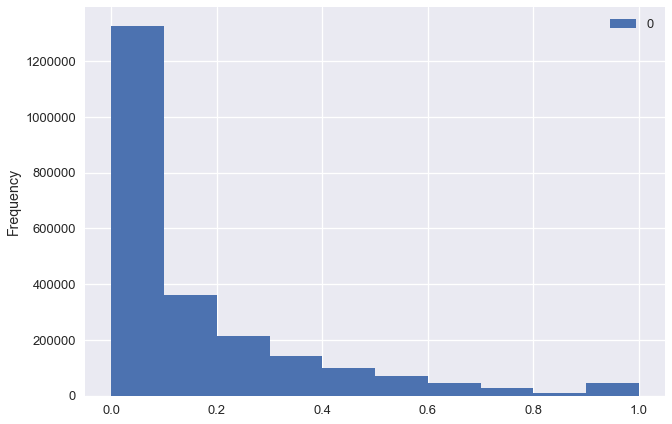

In [41]:
pd.DataFrame(features_test).plot.hist()